# Movie plot analysis

#### We will inspect the plot of movies to detect any change in lexical fields with respect to 9/11.

In [1]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from collections import Counter
from itertools import chain

In [2]:
#Load the data
movies = pd.read_pickle('../data/movies.pkl')
plot_summaries = pd.read_pickle('../data/plot_summaries.pkl')

movies_and_plot = pd.merge(left=movies, right=plot_summaries, on='Wikipedia_movie_ID')
movies_and_plot.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,nb_languages,nb_country,nb_genre,Movie_language,FirstLanguage_Name,SecondLanguage_Name,FirstCountry_Name,SecondCountry_Name,Plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",1,1,7,[English ],English,None,United States of America,None,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01 00:00:00+00:00,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1,1,3,[English ],English,None,United Kingdom,None,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01 00:00:00+00:00,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama],1,1,1,[German ],German,None,Germany,None,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01 00:00:00+00:00,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",1,1,4,[English ],English,None,South Africa,None,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04 00:00:00+00:00,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1,1,7,[English ],English,None,United States of America,None,"Adam, a San Francisco-based artist who works a..."


### Clustering

In [3]:
df_plots = movies_and_plot[['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Plot']]
df_plots

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01 00:00:00+00:00,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01 00:00:00+00:00,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01 00:00:00+00:00,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04 00:00:00+00:00,"Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...
35966,23851782,/m/06_vb43,The Ghost Train,1941-05-03 00:00:00+00:00,{{plot}} The film opens with a Great Western e...
35967,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19 00:00:00+00:00,Two former National Oceanic Atmospheric Admini...
35968,34980460,/m/0g4pl34,Knuckle,2011-01-21 00:00:00+00:00,{{No plot}} This film follows 12 years in the ...
35969,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21 00:00:00+00:00,"The story takes place in the year 2092,The Sup..."


In [4]:
def count_and_expected_number_before_after(df, split=2003):
    df_plots_after = df[df['Movie_release_date'].dt.year > split]
    df_plots_before = df[df['Movie_release_date'].dt.year <= split]

    plots_before = df_plots_before['Plot'].apply(lambda x: x.lower().strip("',.{[}]!?|").split()).to_list()
    plots_after = df_plots_after['Plot'].apply(lambda x: x.lower().strip("',.{[}]!?|").split()).to_list()

    text_before = list(chain.from_iterable(plots_before))
    text_after = list(chain.from_iterable(plots_after))
    
    counter_all = Counter(text_before)
    counter_all.update(text_after)
    
    counter_before = Counter(text_before)
    counter_after = Counter(text_after)

    dict_all, dict_before, dict_after = dict(counter_all), dict(counter_before), dict(counter_after)

    for key in dict_all.keys():
        if key not in dict_before:
            dict_before[key] = 0
        if key not in dict_after:
            dict_after[key] = 0

    dict_all = dict(sorted(dict_all.items()))
    dict_before = dict(sorted(dict_before.items()))
    dict_after = dict(sorted(dict_after.items()))

    for k, v in dict_all.items():
        dict_all[k] = v / len(df_plots)

    for k, v in dict_before.items():
        dict_before[k] = v / len(df_plots_before)

    for k, v in dict_after.items():
        dict_after[k] = v / len(df_plots_after)

    return counter_all, dict_all, counter_before, dict_before, counter_after, dict_after

In [5]:
counter_all, dict_all, counter_before, dict_before, counter_after, dict_after = count_and_expected_number_before_after(df=df_plots, split=2002)

In [6]:
counter_all.most_common(60)

[('the', 685963),
 ('to', 408572),
 ('and', 383448),
 ('a', 314939),
 ('of', 218284),
 ('is', 188677),
 ('in', 182650),
 ('his', 166446),
 ('he', 148038),
 ('with', 117630),
 ('that', 117066),
 ('her', 114754),
 ('for', 80589),
 ('she', 78568),
 ('by', 77924),
 ('as', 74592),
 ('on', 67590),
 ('they', 61533),
 ('but', 60135),
 ('who', 59373),
 ('him', 59218),
 ('at', 54172),
 ('from', 51034),
 ('an', 49071),
 ('has', 48390),
 ('their', 45503),
 ('are', 42865),
 ('when', 42530),
 (',', 37469),
 ('after', 37213),
 ('it', 35363),
 ('into', 32735),
 ('out', 31581),
 ('be', 29571),
 ('up', 28256),
 ('was', 27562),
 ('not', 25498),
 ('one', 24933),
 ('then', 23402),
 ('which', 22596),
 ('them', 22419),
 ('while', 22063),
 ('about', 21506),
 ('have', 20232),
 ('where', 18798),
 ('this', 18752),
 ('will', 18180),
 ('back', 17911),
 ('two', 17840),
 ('all', 17624),
 ('.', 17130),
 ('tells', 16432),
 ('had', 15423),
 ('new', 14820),
 ('only', 14492),
 ('been', 14483),
 ('get', 14439),
 ('him.', 

In [ ]:
for word, count in counter_all.most_common(60):
    dict_before.pop(word)
    dict_after.pop(word)

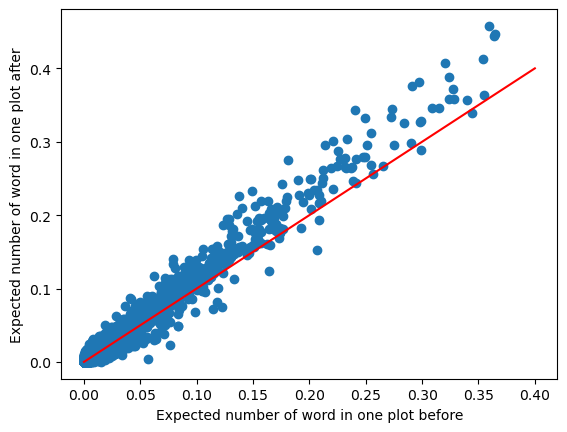

In [16]:
plt.scatter(dict_before.values(), dict_after.values())
plt.plot(np.array([0, 0.4]), np.array([0, 0.4]), color='red')

plt.xlabel('Expected number of word in one plot before')
plt.ylabel('Expected number of word in one plot after')

plt.show()

#### Let us first analyse the plots in a simple manner. Let us check the number of occurences of key words in plots. 

In [10]:
key_words = ['plane', 'tower', 'twin tower', 'terrorism', 'terrorist', 'hijack', 'islam', 'world trade center']
df_plots = movies_and_plot[['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Plot']]

In [11]:

def flag_plot_movie(df, key_words):
    pd.options.mode.chained_assignment = None
    col_name_of_key_words = [word.lower() for word in key_words]

    def flag_count(plot_summary, key_word):
        return 1 if plot_summary.lower().count(key_word) > 0 else 0

    for i in range(len(key_words)):
        col_name = col_name_of_key_words[i][0].upper() + col_name_of_key_words[i][1:]
        df[col_name] = df['Plot'].apply(lambda x: flag_count(x, key_word=col_name_of_key_words[i]))

    pd.options.mode.chained_assignment = 'warn'
    return df


df_plots_flagged = flag_plot_movie(df=df_plots, key_words=key_words)
df_plots_flagged

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Plot,Plane,Tower,Twin tower,Terrorism,Terrorist,Hijack,Islam,World trade center
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,"Set in the second half of the 22nd century, th...",1,0,0,0,0,0,0,0
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01 00:00:00+00:00,A series of murders of rich young women throug...,0,0,0,0,0,0,0,0
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01 00:00:00+00:00,"Eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01 00:00:00+00:00,"Every hundred years, the evil Morgana returns...",0,0,0,0,0,0,0,0
4,6631279,/m/0gffwj,Little city,1997-04-04 00:00:00+00:00,"Adam, a San Francisco-based artist who works a...",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35966,23851782,/m/06_vb43,The Ghost Train,1941-05-03 00:00:00+00:00,{{plot}} The film opens with a Great Western e...,0,0,0,0,0,0,0,0
35967,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19 00:00:00+00:00,Two former National Oceanic Atmospheric Admini...,0,0,0,0,0,0,0,0
35968,34980460,/m/0g4pl34,Knuckle,2011-01-21 00:00:00+00:00,{{No plot}} This film follows 12 years in the ...,0,0,0,0,0,0,0,0
35969,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21 00:00:00+00:00,"The story takes place in the year 2092,The Sup...",0,0,0,0,0,0,0,0


In [12]:
def occ_by_year(df, key_words):
    col_name_of_key_words = [word[0].upper() + word[1:] for word in key_words]
    df_key_words_occ = df.groupby(by=df['Movie_release_date'].dt.year)[col_name_of_key_words].sum()
    df_key_words_occ['Movies'] = df.groupby(by=df['Movie_release_date'].dt.year)['Wikipedia_movie_ID'].count()

    return df_key_words_occ.copy(deep=True)


df_key_words_occ = occ_by_year(df=df_plots_flagged, key_words=key_words)
df_key_words_occ


,Plane,Tower,Twin tower,Terrorism,Terrorist,Hijack,Islam,World trade center,Movies
Movie_release_date,,,,,,,,,
1894.0,0,0,0,0,0,0,0,0,2
1895.0,0,0,0,0,0,0,0,0,1
1896.0,0,0,0,0,0,0,0,0,3
1898.0,0,0,0,0,0,0,0,0,5
1899.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
2010.0,41,12,0,4,36,7,13,2,1060
2011.0,28,14,0,1,10,4,4,1,784
2012.0,23,10,0,1,11,5,2,0,530


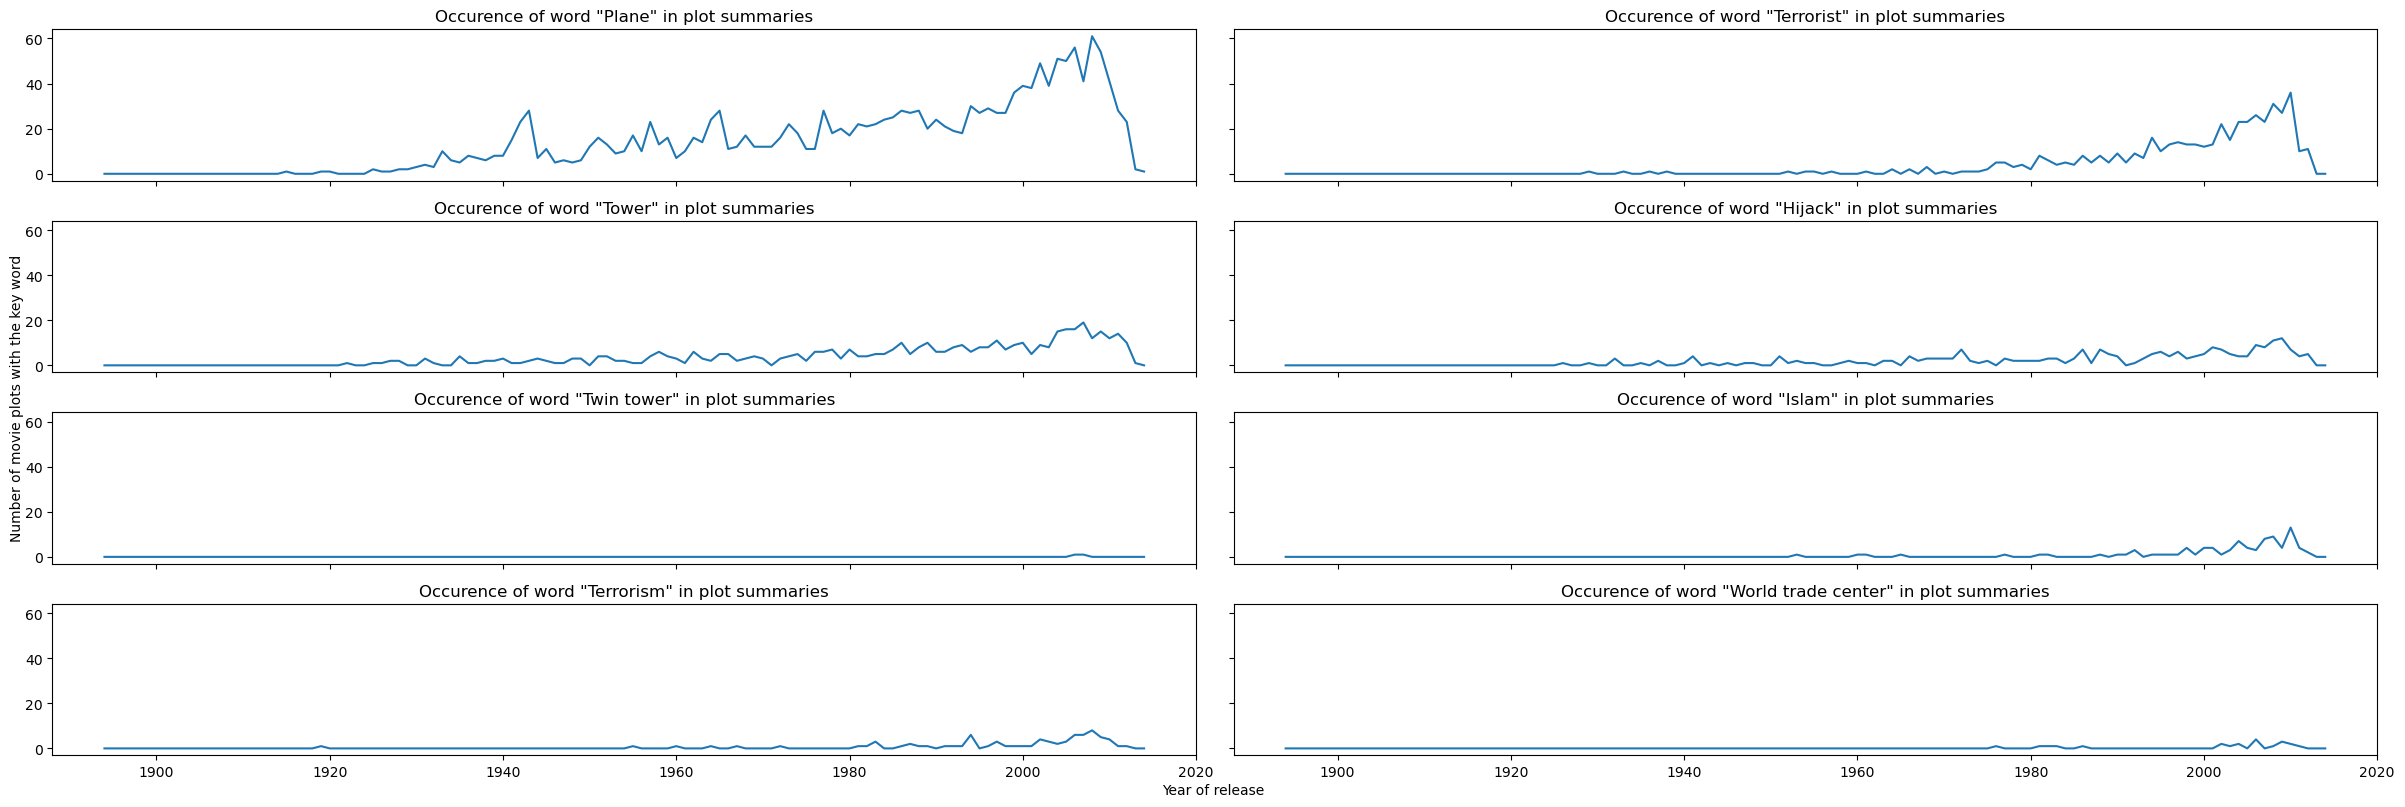

In [13]:
def plot_occ_by_year(df, key_words):
    col_name_of_key_words = [word[0].upper() + word[1:] for word in key_words]
    fig, ax = plt.subplots(math.ceil(len(key_words)/2), 2, figsize= (math.ceil(len(key_words)/2)*6, 8), sharey = True, sharex = True)

    for i in range(len(key_words)):
        sbplt = ax[i%math.ceil(len(key_words)/2), math.floor(i/math.ceil(len(key_words)/2))]
        col_name = col_name_of_key_words[i]

        sbplt.plot(df[col_name])
        sbplt.set_title('Occurence of word "' + col_name_of_key_words[i] + '" in plot summaries')
        
    if (len(key_words) % 2 != 0):
        fig.delaxes(ax[math.floor(len(key_words)/2), 1])

    fig.tight_layout()

    fig.text(0.48,0, "Year of release")
    fig.text(0,0.32, "Number of movie plots with the key word", rotation = 90)


plot_occ_by_year(df_key_words_occ, key_words)

#### Now by percentage 

In [14]:
def percentage_of_movies_with_key_words_before_after(df, mid_value=2003, horizon_years=10):
    df_occ= df.reset_index()
    before_horizon = mid_value - horizon_years
    after_horizon = mid_value + horizon_years

    df_occ_before = df_occ[(before_horizon <= df_occ['Movie_release_date']) * (df_occ['Movie_release_date'] < mid_value) == 1]
    df_occ_after = df_occ[(mid_value <= df_occ['Movie_release_date'])  * (df_occ['Movie_release_date'] < after_horizon) == 1]

    df_res = pd.DataFrame(data={
    f'{before_horizon}-{mid_value - 1}': df_occ_before.sum() / df_occ_before['Movies'].sum(),
    f'{mid_value}-{after_horizon - 1}': df_occ_after.sum() / df_occ_after['Movies'].sum()
    })

    df_res = df_res.drop(['Movie_release_date', 'Movies']).map(lambda x: str(round(x*100, 3)) + '%')

    return df_res

In [15]:
df_percentage_before_after = percentage_of_movies_with_key_words_before_after(df=df_key_words_occ, horizon_years=10)
df_percentage_before_after

,1993-2002,2003-2012
Plane,5.21%,4.118%
Tower,1.335%,1.271%
Twin tower,0.0%,0.019%
Terrorism,0.309%,0.362%
Terrorist,2.165%,2.087%
Hijack,0.83%,0.64%
Islam,0.293%,0.529%
World trade center,0.033%,0.13%


It is interesting to see that for the word "plane", it is less used after 9/11 than before, even though you would expect to have more.

### Clustering